In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np 
from vqls import *
from utils import *


file_path = "results_tanh_3.json"

In [21]:
df = pd.read_json(file_path)
df.head()

,Condition number,norm(yk),training_cost,exe_time,in_train_weights,RSS_q,RSS_h,seed
0,62.475139,1.603073,"[0.4348289428, 0.3989506389, 0.4119403755, 0.4...",9608.713263,"[[0.6352372396, 2.4647289895, 2.7034574689, 1....",3.731439,3.633572,74
1,62.475139,1.603073,"[0.2195052284, 0.343047099, 0.3431557199, 0.33...",12773.926968,"[[2.6293375123000002, 3.0480858247000002, 1.40...",8.437812,7.283921,97
2,62.475139,1.603073,"[0.2606606527, 0.1739665787, 0.3675744081, 0.2...",19323.466537,"[[2.5901472486, 0.5697269873, 2.7562033298, 1....",3.606715,3.518816,61
3,62.475139,1.603073,"[0.3673084908, 0.4507424739, 0.4933786289, 0.4...",6753.706809,"[[0.8075226007, 2.1481820476, 2.0848920702, 2....",3.305360,3.218874,83
4,62.475139,1.603073,"[0.49129187150000003, 0.4321070031, 0.41697390...",9330.389433,"[[1.5728953076, 1.4704771867, 1.5732547036, 0....",8.432703,7.247416,79


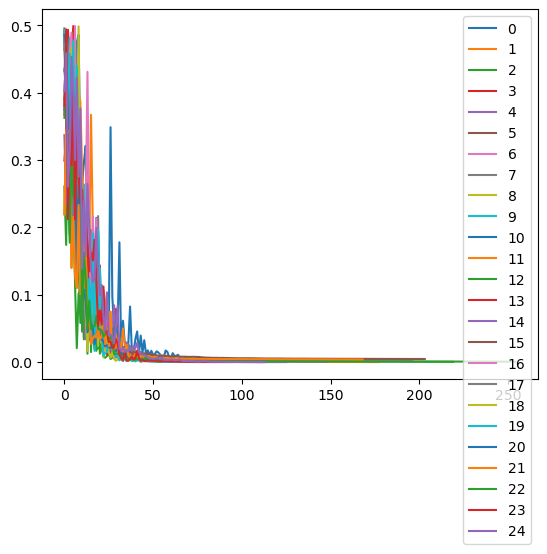

In [22]:
#Visualize training cost and obtain best performing epoch
argM = []
for i,item in enumerate(df["training_cost"].values):
    argM.append(np.argmin(item))
    plt.plot(item, label = i)
plt.legend()

In [26]:
## experimental specific settings
label = 'tanh'
nq = 3
n_step = 8

In [27]:

func_out = {'sigmoid': sigmoid_t,'tanh': tanh_t,'elu': elu_t, 'relu': relu_t, 'sin':sin_m}
func = func_out[label]


#############################################################################################
###################################### System Preparatio and _sin_#################
#############################################################################################

lower = 0. 
upper = 1. 
f_i = 0.0 
scaled=True
x = np.arange(lower, upper + .03, (upper-lower)/n_step).tolist() 
xx = np.linspace(lower, upper, n_step) ##inputs sampling in the interval 0,1
y = [func(value,f_i) for value in x]

if scaled:
    norm = np.linalg.norm(y)
    y = y / norm

tck=splrep(x,y,k=1) #coeffs
matrix,vector,v_norm = GeneralizedVQS_System(n_step,label,x,xx,scaled=scaled)


#############################################################################################
################################# VQLS and Linear Prob. Solving #############################
#############################################################################################


k_numb=np.linalg.cond(np.array(matrix))

vqls_circuit = VQLS(matrix,v_norm,nq,opt='COBYLA') 


C:\Users\orazi\AppData\Local\Temp\ipykernel_8948\1172508927.py:19: RuntimeWarning: invalid value encountered in divide
  y = y / norm


beta_classic                 : [ 0.07435902  0.15155621 -0.06517749  0.81343083 -0.46007092  0.96832903
  0.22579632  0.54944296]


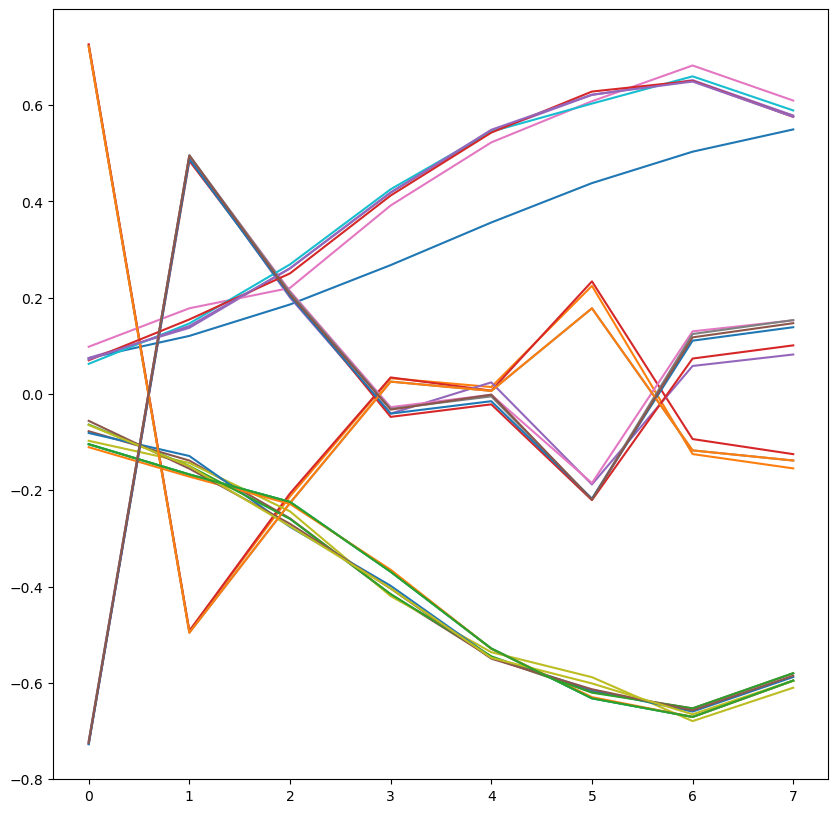

In [28]:
c = np.linalg.solve(matrix,vector)
print('beta_classic                 :',c)
plt.figure(figsize=(10,10))

y_c=np.dot(matrix,c) #classic
plt.plot(range(len(y_c)),y_c, label="classical")

for i,item in enumerate(df['in_train_weights']):
  weights = item[argM[i]]
  q = vqls_circuit.solution(weights).real
  y_q=np.dot(matrix,q) #hybrid
                        #Quantum

  y_fq=[]
  for el in matrix:
    y_fq.append(vqls_circuit.direct_prod2(weights,el))

  #plt.plot(range(len(y_fq)),y_q,label= f"h {i}")
  plt.plot(range(len(y_fq)),y_fq, label= f"fq {i}")
#plt.legend()

In [29]:
best = np.argmin(df['RSS_q'])
weights = df['in_train_weights'][best][argM[best]]


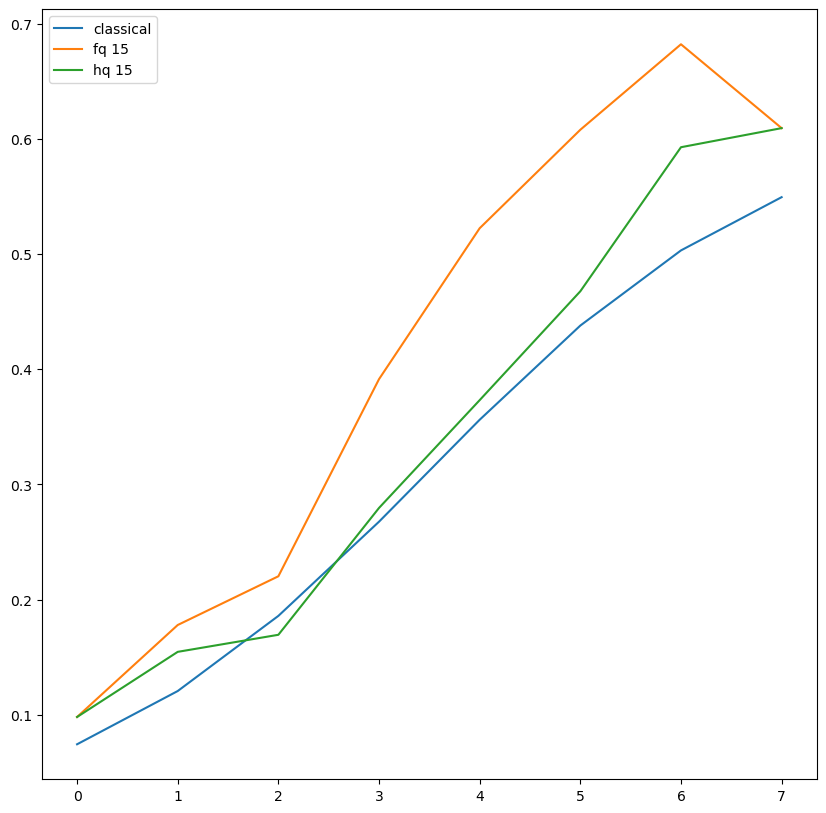

In [30]:
#Best performing model based on RSS

best = np.argmin(df['RSS_q'])
weights = df['in_train_weights'][best][argM[best]]
q = vqls_circuit.solution(weights).real
y_q=np.dot(matrix,q) #hybrid
                  #Quantum
plt.figure(figsize=(10,10))
plt.plot(range(len(y_c)),y_c, label="classical")

y_fq=[]
for el in matrix:
  y_fq.append(vqls_circuit.direct_prod2(weights,el))

#plt.plot(range(len(y_fq)),y_q,label= f"h {i}")
plt.plot(range(len(y_fq)),np.abs(y_fq), label= f"fq {best}")
plt.plot(range(len(y_fq)),np.abs(y_q), label= f"hq {best}")
plt.legend()